In [1]:
from Bio import Entrez, Medline, Seq, SeqIO, SeqRecord
from collections import defaultdict
import functools
import gzip
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import HTSeq
import pysam
from cyvcf2 import VCF

/home/veysel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
Entrez.email = "veyselsapan1@gmail.com"

In [20]:
dir(SeqRecord.SeqRecord)

['_AnnotationsDict',
 '_AnnotationsDictValue',
 '__add__',
 '__annotations__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_from_validated',
 'count',
 'format',
 'islower',
 'isupper',
 'letter_annotations',
 'lower',
 'reverse_complement',
 'seq',
 'translate',
 'upper']

In [3]:
handle = Entrez.esearch(db="nucleotide", term='CRT[Gene Name] AND "Plasmodium falciparum"[Organism]')
rec_list = Entrez.read(handle)
if int(rec_list["RetMax"]) < int(rec_list["Count"]):
    handle = Entrez.esearch(db="nucleotide",
                            term='CRT[Gene Name] AND "Plasmodium falciparum"[Organism]',
                            retmax= rec_list["Count"])
    rec_list = Entrez.read(handle)

In [4]:
id_list = rec_list["IdList"]
hdl = Entrez.efetch(db="nucleotide", id=id_list, rettype="gb")

In [5]:
recs = list(SeqIO.parse(hdl, 'gb'))

In [6]:
for rec in recs:
    if rec.name == 'KM288867':
        break
print(rec.name)
print(rec.description)

KM288867
Plasmodium falciparum clone PF3D7_0709000 chloroquine resistance transporter (CRT) gene, complete cds


In [7]:
for feature in rec.features:
    if feature.type == 'gene':
        print(feature.qualifiers['gene'])
    elif feature.type == 'exon':
        loc = feature.location
        print(loc.start, loc.end, loc.strand)
    else:
        print('not processed:\n%s' %feature)

not processed:
type: source
location: [0:10000](+)
qualifiers:
    Key: clone, Value: ['PF3D7_0709000']
    Key: db_xref, Value: ['taxon:5833']
    Key: mol_type, Value: ['genomic DNA']
    Key: organism, Value: ['Plasmodium falciparum']

['CRT']
not processed:
type: mRNA
location: join{[2751:3543](+), [3720:3989](+), [4168:4341](+), [4513:4646](+), [4799:4871](+), [4994:5070](+), [5166:5249](+), [5376:5427](+), [5564:5621](+), [5769:5862](+), [6055:6100](+), [6247:6302](+), [6471:7598](+)}
qualifiers:
    Key: gene, Value: ['CRT']
    Key: product, Value: ['chloroquine resistance transporter']

not processed:
type: 5'UTR
location: [2751:3452](+)
qualifiers:
    Key: gene, Value: ['CRT']

not processed:
type: primer_bind
location: [2935:2958](+)
qualifiers:

not processed:
type: primer_bind
location: [3094:3121](+)
qualifiers:

not processed:
type: CDS
location: join{[3452:3543](+), [3720:3989](+), [4168:4341](+), [4513:4646](+), [4799:4871](+), [4994:5070](+), [5166:5249](+), [5376:54

In [12]:
for name, value in rec.annotations.items():
    print('%s=%s' % (name, value))

molecule_type=DNA
topology=linear
data_file_division=INV
date=12-NOV-2014
accessions=['KM288867']
sequence_version=1
keywords=['']
source=Plasmodium falciparum (malaria parasite P. falciparum)
organism=Plasmodium falciparum
taxonomy=['Eukaryota', 'Sar', 'Alveolata', 'Apicomplexa', 'Aconoidasida', 'Haemosporida', 'Plasmodiidae', 'Plasmodium', 'Plasmodium (Laverania)']
references=[Reference(title='Versatile control of Plasmodium falciparum gene expression with an inducible protein-RNA interaction', ...), Reference(title='Direct Submission', ...)]


In [26]:
print(len(rec.seq))

10000


In [31]:
refs = rec.annotations['references']
for ref in refs:
    if ref.pubmed_id !='':
        print(ref.pubmed_id)
        handle = Entrez.efetch(db='pubmed', id=[ref.pubmed_id], rettype='medline', retmode='text')
        records = Medline.parse(handle)
        for med_rec in records:
            for k, v in med_rec.items():
                print('%s : %s' % (k, v))

25370483
PMID : 25370483
OWN : NLM
STAT : MEDLINE
DCOM : 20160112
LR : 20181113
IS : 2041-1723 (Electronic) 2041-1723 (Linking)
VI : 5
DP : 2014 Nov 5
TI : Versatile control of Plasmodium falciparum gene expression with an inducible protein-RNA interaction.
PG : 5329
LID : 10.1038/ncomms6329 [doi]
AB : The available tools for conditional gene expression in Plasmodium falciparum are limited. Here, to enable reliable control of target gene expression, we build a system to efficiently modulate translation. We overcame several problems associated with other approaches for regulating gene expression in P. falciparum. Specifically, our system functions predictably across several native and engineered promoter contexts, and affords control over reporter and native parasite proteins irrespective of their subcellular compartmentalization. Induction and repression of gene expression are rapid, homogeneous and stable over prolonged periods. To demonstrate practical application of our system, we u

In [33]:
hdl = Entrez.efetch(db='nucleotide', id=['NM_002299'], rettype='gb')
gb_rec = SeqIO.read(hdl, 'gb')
for feature in gb_rec.features:
    if feature.type == 'CDS':
        location = feature.location
cds = SeqRecord.SeqRecord(gb_rec.seq[location.start:location.end], 'NM_002299', description='LCT CDS only')
w_hdl = open('example.fasta', 'w')
SeqIO.write([cds], w_hdl, 'fasta')
w_hdl.close()
recs = SeqIO.parse('example.fasta', 'fasta')
for rec in recs:
    seq= rec.seq
    print(rec.description)
    print(seq[:30])

NM_002299 LCT CDS only
ATGGAGCTGTCTTGGCATGTAGTCTTTATT


In [34]:
rna = seq.transcribe()

In [35]:
print(rna)

AUGGAGCUGUCUUGGCAUGUAGUCUUUAUUGCCCUGCUAAGUUUUUCAUGCUGGGGGUCAGACUGGGAGUCUGAUAGAAAUUUCAUUUCCACCGCUGGUCCUCUAACCAAUGACUUGCUGCACAACCUGAGUGGUCUCCUGGGAGACCAGAGUUCUAACUUUGUAGCAGGGGACAAAGACAUGUAUGUUUGUCACCAGCCACUGCCCACUUUCCUGCCAGAAUACUUCAGCAGUCUCCAUGCCAGUCAGAUCACCCAUUAUAAGGUAUUUCUGUCAUGGGCACAGCUCCUCCCAGCAGGAAGCACCCAGAAUCCAGACGAGAAAACAGUGCAGUGCUACCGGCGACUCCUCAAGGCCCUCAAGACUGCACGGCUUCAGCCCAUGGUCAUCCUGCACCACCAGACCCUCCCUGCCAGCACCCUCCGGAGAACCGAAGCCUUUGCUGACCUCUUCGCCGACUAUGCCACAUUCGCCUUCCACUCCUUCGGGGACCUAGUUGGGAUCUGGUUCACCUUCAGUGACUUGGAGGAAGUGAUCAAGGAGCUUCCCCACCAGGAAUCAAGAGCGUCACAACUCCAGACCCUCAGUGAUGCCCACAGAAAAGCCUAUGAGAUUUACCACGAAAGCUAUGCUUUUCAGGGCGGAAAACUCUCUGUUGUCCUGCGAGCUGAAGAUAUCCCGGAGCUCCUGCUAGAACCACCCAUAUCUGCGCUUGCCCAGGACACGGUCGAUUUCCUCUCUCUUGAUUUGUCUUAUGAAUGCCAAAAUGAGGCAAGUCUGCGGCAGAAGCUGAGUAAAUUGCAGACCAUUGAGCCAAAAGUGAAAGUUUUCAUCUUCAACCUAAAACUCCCAGACUGCCCCUCCACCAUGAAGAACCCAGCCAGUCUGCUCUUCAGCCUUUUUGAAGCCAUAAAUAAAGACCAAGUGCUCACCAUUGGGUUUGAUAUUAAUGAGUUUCUGAGUUGUUCAUCAAGUUCCAAGAAAAGCAUGUCUUGUUCUC

In [36]:
prot = rna.translate()
print(prot)

MELSWHVVFIALLSFSCWGSDWESDRNFISTAGPLTNDLLHNLSGLLGDQSSNFVAGDKDMYVCHQPLPTFLPEYFSSLHASQITHYKVFLSWAQLLPAGSTQNPDEKTVQCYRRLLKALKTARLQPMVILHHQTLPASTLRRTEAFADLFADYATFAFHSFGDLVGIWFTFSDLEEVIKELPHQESRASQLQTLSDAHRKAYEIYHESYAFQGGKLSVVLRAEDIPELLLEPPISALAQDTVDFLSLDLSYECQNEASLRQKLSKLQTIEPKVKVFIFNLKLPDCPSTMKNPASLLFSLFEAINKDQVLTIGFDINEFLSCSSSSKKSMSCSLTGSLALQPDQQQDHETTDSSPASAYQRIWEAFANQSRAERDAFLQDTFPEGFLWGASTGAFNVEGGWAEGGRGVSIWDPRRPLNTTEGQATLEVASDSYHKVASDVALLCGLRAQVYKFSISWSRIFPMGHGSSPSLPGVAYYNKLIDRLQDAGIEPMATLFHWDLPQALQDHGGWQNESVVDAFLDYAAFCFSTFGDRVKLWVTFHEPWVMSYAGYGTGQHPPGISDPGVASFKVAHLVLKAHARTWHHYNSHHRPQQQGHVGIVLNSDWAEPLSPERPEDLRASERFLHFMLGWFAHPVFVDGDYPATLRTQIQQMNRQCSHPVAQLPEFTEAEKQLLKGSADFLGLSHYTSRLISNAPQNTCIPSYDTIGGFSQHVNHVWPQTSSSWIRVVPWGIRRLLQFVSLEYTRGKVPIYLAGNGMPIGESENLFDDSLRVDYFNQYINEVLKAIKEDSVDVRSYIARSLIDGFEGPSGYSQRFGLHHVNFSDSSKSRTPRKSAYFFTSIIEKNGFLTKGAKRLLPPNTVNLPSKVRAFTFPSEVPSKAKVVWEKFSSQPKFERDLFYHGTFRDDFLWGVSSSAYQIEGAWDADGKGPSIWDNFTHTPGSNVKDNATGDIACDSYHQLDADLNMLRALKVKAYRFSISWSRIFPTGRNSSINSHGVDYY

In [49]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
rec = next(recs)
print(rec.id, '\n', rec.description, '\n', rec.seq)
print(rec.letter_annotations) # rec.letter_annotations (quality score)

SRR003265.31 
 SRR003265.31 3042NAAXX:3:1:1252:1819 length=51 
 GGGAAAAGAAAAACAAACAAACAAAAACAAAACACAGAAACAAAAAAACCA
{'phred_quality': [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 30, 23, 40, 32, 35, 29, 40, 16, 40, 40, 32, 35, 31, 40, 40, 39, 22, 40, 24, 20, 28, 31, 12, 31, 10, 22, 28, 13, 26, 20, 23, 23]}


In [50]:
cnt = defaultdict(int)
for rec in recs:
    for letter in rec:
        cnt[letter] += 1
total_sum = sum(cnt.values())
for letter, cnt in cnt.items():
    #print('%s: %.2f %d' % (letter, 100. * cnt / tot,cnt))
    print("{}: {:.2f} {}".format(letter, 100.*cnt/total_sum, cnt))

G: 20.68 5359329
A: 28.60 7411928
T: 29.58 7666885
C: 21.00 5444044
N: 0.14 37289


Text(0, 0.5, 'Number of N calls')

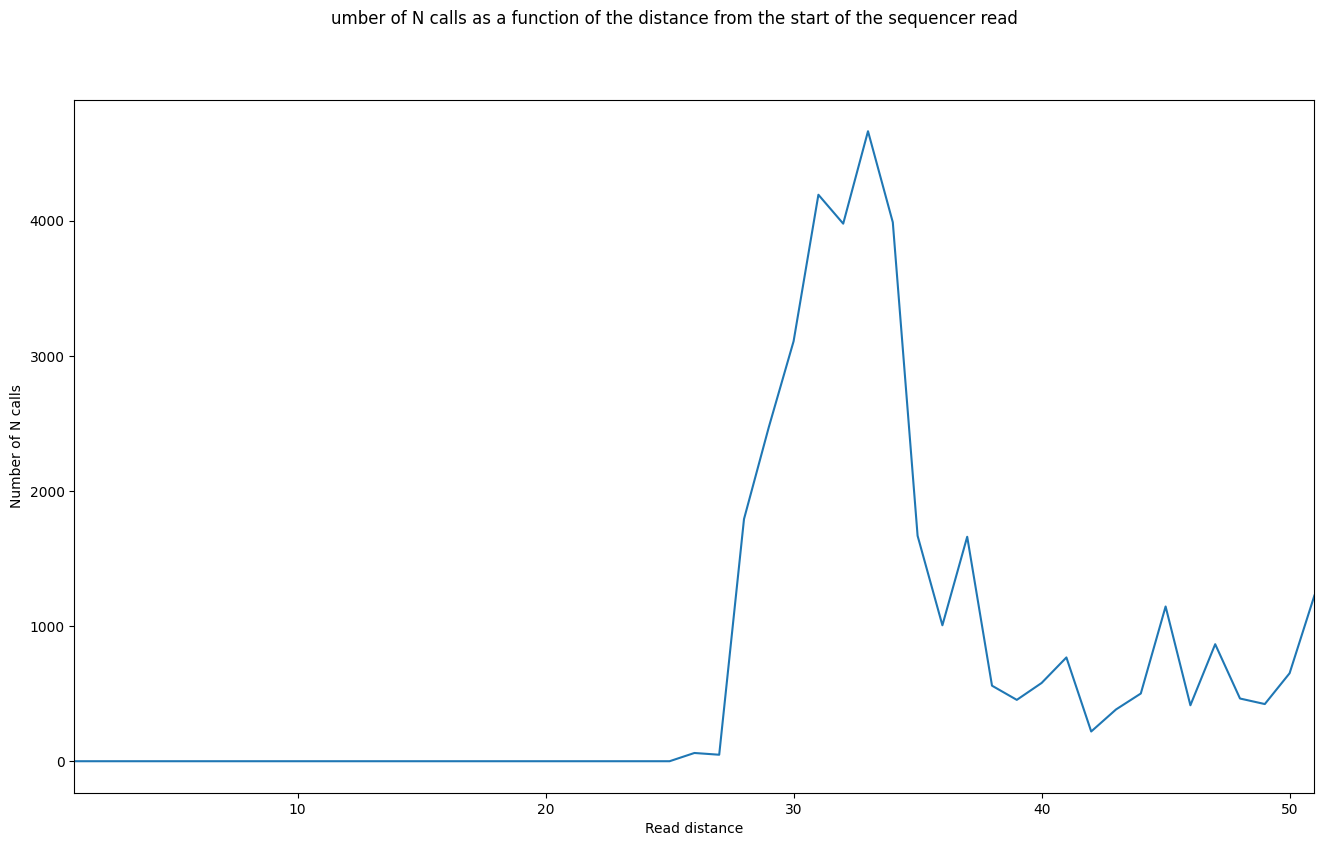

In [57]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
n_cnt = defaultdict(int)
for rec in recs:
    for i, letter in enumerate(rec.seq):
        pos = i + 1
        if letter == 'N':
            n_cnt[pos] += 1
seq_len = max(n_cnt.keys())
positions = range(1, seq_len + 1)
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(positions, [n_cnt[x] for x in positions])
fig.suptitle('umber of N calls as a function of the distance from the start of the sequencer read')
ax.set_xlim(1, seq_len)
ax.set_xlabel("Read distance")
ax.set_ylabel("Number of N calls")

In [60]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
cnt_qual = defaultdict(int)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25:
            continue
        cnt_qual[qual] += 1
tot = sum(cnt_qual. values())
for qual, cnt in cnt_qual.items():
    print("{}: {:.2f} {}".format(qual, 100*cnt/tot, cnt))

40: 22.76 3007221
16: 2.05 270431
32: 1.03 136763
35: 0.91 120704
31: 1.08 142464
39: 0.78 102568
22: 1.59 209905
24: 1.46 193259
20: 1.73 228923
28: 1.23 162226
12: 2.35 309918
10: 4.95 654154
13: 2.28 301033
26: 1.33 176263
23: 1.52 201164
37: 0.84 111179
34: 0.95 125624
21: 1.66 219602
30: 1.13 149449
33: 0.99 131291
25: 1.40 184846
17: 1.97 259779
38: 0.80 106290
4: 4.77 630923
36: 0.88 115701
18: 1.88 248982
11: 2.41 318303
19: 1.81 239621
5: 4.88 645266
9: 2.51 332259
3: 4.04 533458
27: 1.28 168902
8: 2.53 334410
29: 1.17 154892
15: 2.12 280719
7: 2.51 331743
2: 3.77 498679
14: 2.20 291341
6: 2.50 330834
1: 1.52 200558
0: 0.40 52229


/tmp/ipykernel_73579/1663673702.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(x) for x in range(25, max(qual_pos.keys()) + 1)])


Text(0.5, 0.98, 'Distribution of PHRED scores as a function of read distance')

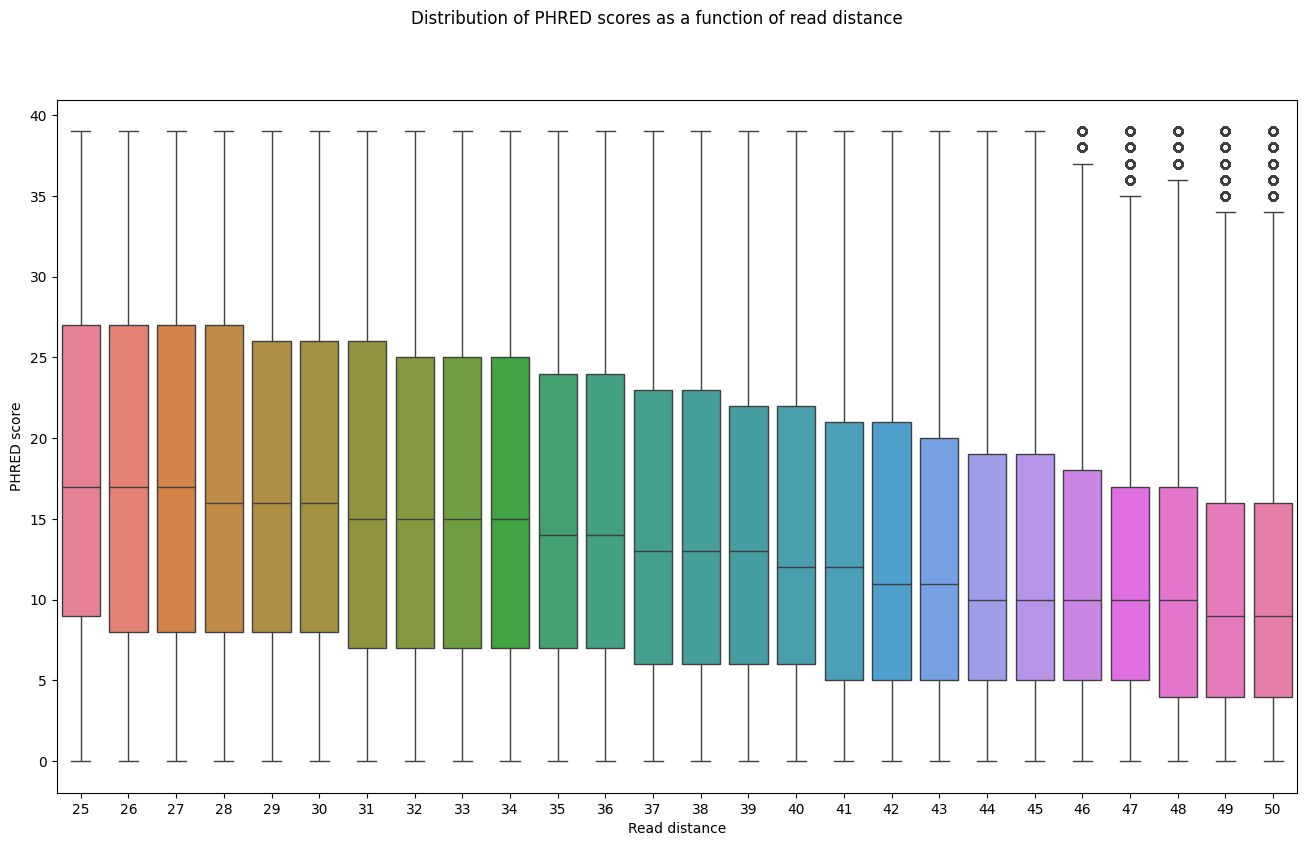

In [62]:
recs = SeqIO.parse(gzip.open('SRR003265.filt.fastq.gz', 'rt', encoding='utf-8'), 'fastq')
qual_pos = defaultdict(list)
for rec in recs:
    for i, qual in enumerate(rec.letter_annotations['phred_quality']):
        if i < 25 or qual == 40:
            continue
        pos = i + 1
        qual_pos[pos].append(qual)
vps = []
poses = list(qual_pos.keys())
poses.sort()
for pos in poses:
    vps.append(qual_pos[pos])
fig, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=vps, ax=ax)
ax.set_xticklabels([str(x) for x in range(25, max(qual_pos.keys()) + 1)])
ax.set_xlabel('Read distance')
ax.set_ylabel('PHRED score')
fig.suptitle('Distribution of PHRED scores as a function of read distance')
        

In [63]:
f1 = gzip.open('XA_1.filt.fastq.gz', 'rt', encoding='utf-8')
f2 = gzip.open('XA_2.filt.fastq.gz', 'rt', encoding='utf-8')
recs1 = SeqIO.parse(f1, 'fastq')
recs2 = SeqIO.parse(f2, 'fastq')
cnt = 0
for rec1, rec2 in zip(recs1, recs2):
    cnt += 1
print('Number of pairs : %d' % cnt)

Number of pairs : 508226


In [66]:
bam = pysam.AlignmentFile('NA18489.chrom20.ILLUMINA.bwa.YRI.exome.20121211.bam', 'rb')
headers = bam.header
for record_type, records in headers.items():
    print(record_type)
    for i, record in enumerate(records):
        if type(record) == dict:
            print('\t{}'.format(i+1))
            for field, value in record.items():
                print('\t\t{}\t{}'.format(field, value))
        else:
            print('\t\t{}'.format(record))

HD
		VN
		SO
SQ
	1
		SN	1
		LN	249250621
		M5	1b22b98cdeb4a9304cb5d48026a85128
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	2
		SN	2
		LN	243199373
		M5	a0d9851da00400dec1098a9255ac712e
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	3
		SN	3
		LN	198022430
		M5	fdfd811849cc2fadebc929bb925902e5
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	4
		SN	4
		LN	191154276
		M5	23dccd106897542ad87d2765d28a19a1
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz        AS:NCBI37       SP:Human
	5
		SN	5
		LN	180915260
		M5	0740173db9ffd264d728f32784845cd7
		UR	ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_as

In [67]:
"""
rec.cigarstring is a human-readable representation of the read’s CIGAR string, e.g. "2S50M1D48M".
The code checks .find('M') and .find('S') to see if 'M' (match/mismatch) and 'S' (soft-clip) 
operations occur in the CIGAR string. find() returns -1 if the substring is not found, 
so > -1 ensures it is found.
The read has both 'M' and 'S' in its CIGAR (so it’s partially aligned with a soft-clip region).
The read itself is mapped (not rec.is_unmapped).
Its mate is also mapped (not rec.mate_is_unmapped).
"""
for rec in bam:
    if rec.cigarstring.find('M') > -1 and rec.cigarstring.find('S') > -1 and not rec.is_unmapped and not rec.mate_is_unmapped:
        break
"""
rec.query_name: The read name (often the identifier from the FASTQ, 
e.g. @M00716:49:000000000-A34B0:1:1101:17612:1454 without the leading @).
rec.reference_id: The numeric ID of the reference sequence, as stored internally 
in the BAM header. For example, 0 might be chr1, 1 might be chr2, etc.
bam.getrname(rec.reference_id): The string reference name (e.g. chr20) 
corresponding to that numeric ID.
rec.reference_start: The 0-based start position of the alignment on the reference.
rec.reference_end: The 0-based end position (exclusive) on the reference. 
(In many contexts, this is one past the last aligned base.)
"""
print(rec.query_name, rec.reference_id, bam.getrname(rec.reference_id), rec.reference_start, rec.reference_end)
print(rec.cigarstring)
"""
rec.query_alignment_start: The 0-based start of the aligned portion in the read’s sequence. 
(Not on the reference, but on the read itself.)
rec.query_alignment_end: The 0-based end of the aligned portion in the read’s sequence.
rec.query_alignment_length: The length (in bases) of the aligned portion on the read.
For example, if the read has 2 soft-clipped bases at the start, the aligned portion 
might begin at index 2 in the read. So query_alignment_start could be 2, etc.
"""
print(rec.query_alignment_start, rec.query_alignment_end, rec.query_alignment_length)
"""
In a paired-end context:
rec.next_reference_id: The numeric ID of the mate’s reference (often the same 
chromosome if it’s properly paired, but sometimes different).
rec.next_reference_start: The 0-based start position where the mate is aligned.
rec.template_length: Also known as insert size. It’s typically the number of bases 
from the start of one mate alignment to the end of the other. 
A positive or negative sign indicates orientation (depending on the library prep).
"""
print(rec.next_reference_id, rec.next_reference_start,rec.template_length)
print(rec.is_paired, rec.is_proper_pair, rec.is_unmapped, rec.mapping_quality)
"""
rec.query_qualities: A list of Phred-scaled quality scores (integers) for each base 
in the read, corresponding to the read’s full length (including soft-clipped bases).
"""
print(rec.query_qualities)
"""
rec.query_alignment_qualities: Similar to query_qualities but typically only for 
the aligned portion of the read. Soft-clipped bases are excluded here.
If the read is 100 bases long, rec.query_qualities might be a list of length 100, 
e.g., [33, 37, 37, 37, 37, ...] (the numeric form of Q-scores). 
By contrast, if 2 bases are soft-clipped, then query_alignment_qualities might have length 98.
"""
print(rec.query_alignment_qualities)
print(rec.query_sequence)

SRR100025.62130839 19 20 59996 60048
52M24S
0 52 52
19 60228 295
True True False 60
array('B', [33, 34, 36, 33, 39, 34, 33, 38, 39, 34, 40, 35, 40, 40, 32, 40, 38, 33, 35, 38, 33, 39, 40, 34, 37, 39, 36, 30, 36, 37, 34, 35, 34, 40, 37, 34, 38, 28, 40, 40, 38, 32, 33, 32, 36, 34, 37, 24, 34, 35, 31, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
array('B', [33, 34, 36, 33, 39, 34, 33, 38, 39, 34, 40, 35, 40, 40, 32, 40, 38, 33, 35, 38, 33, 39, 40, 34, 37, 39, 36, 30, 36, 37, 34, 35, 34, 40, 37, 34, 38, 28, 40, 40, 38, 32, 33, 32, 36, 34, 37, 24, 34, 35, 31, 2])
CTCAGATCCAGAGGTGGAAGAGGAAGGAAGCTTGGAACCCTATAGAGTTGCTGAGTGCCAGGACCAGATACTGGGC


Text(0.5, 0.98, 'Percentage of mapped calls as a function of the position from the start of the sequencer read')

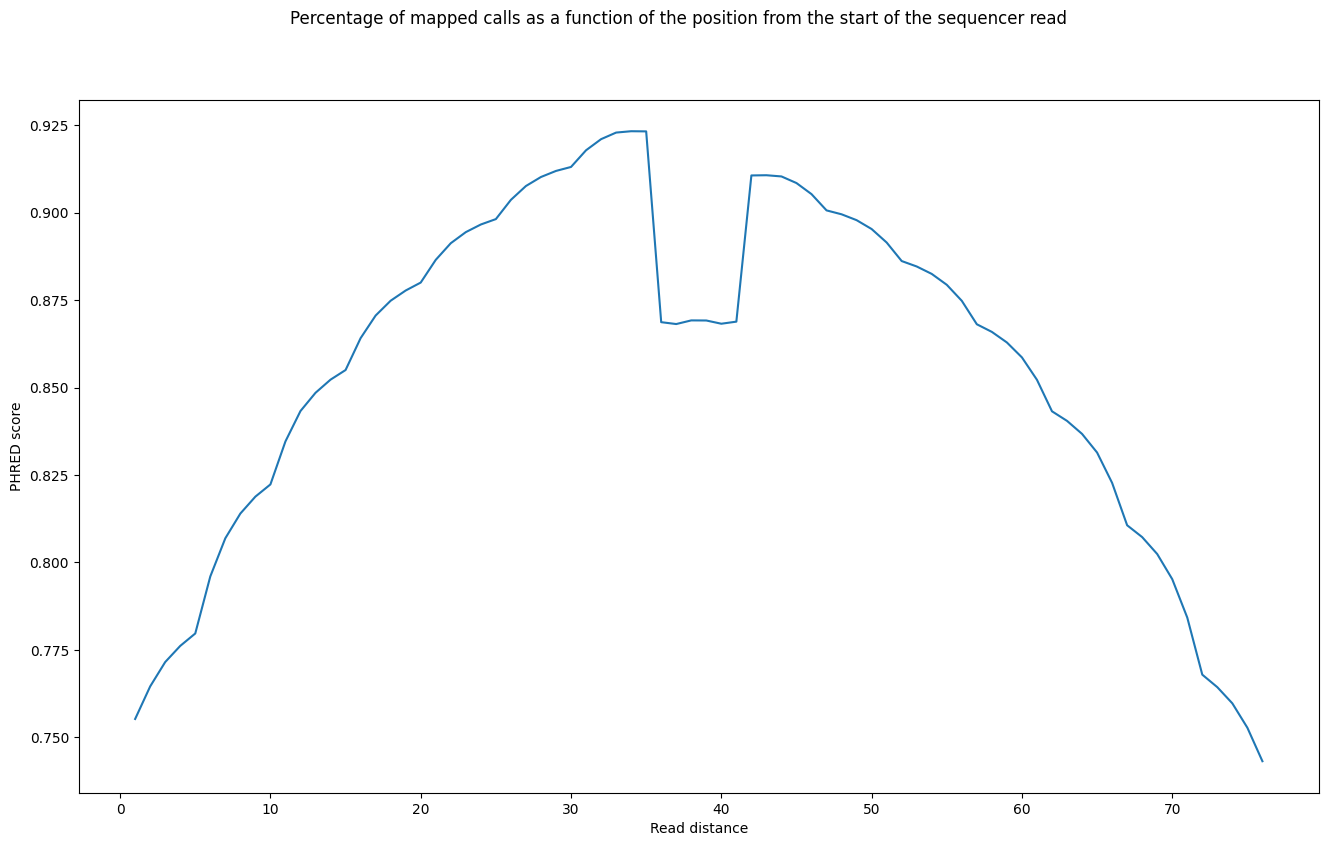

In [70]:
"""
this snippet is iterating over reads in a BAM file (on chromosome 20, positions 0–10,000,000)
and then tracking how many reads are “mapped” at each read position 
(from the first base in the read through the 76th base).
"""
counts = [0] * 76
"""
bam.fetch('20', 0, 10000000) iterates over all reads in the BAM file that align to chromosome
'20' in the region 0–10,000,000 on the reference genome.
"""
for n, rec in enumerate(bam.fetch('20', 0, 10000000)):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
        counts[i] += 1
freqs = [x / (n + 1.) for x in counts]
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(range(1,77), freqs)
ax.set_xlabel('Read distance')
ax.set_ylabel('PHRED score')
fig.suptitle('Percentage of mapped calls as a function of the position from the start of the sequencer read')

Text(0.5, 0.98, 'Distribution of PHRED scores as a function of the position in the read')

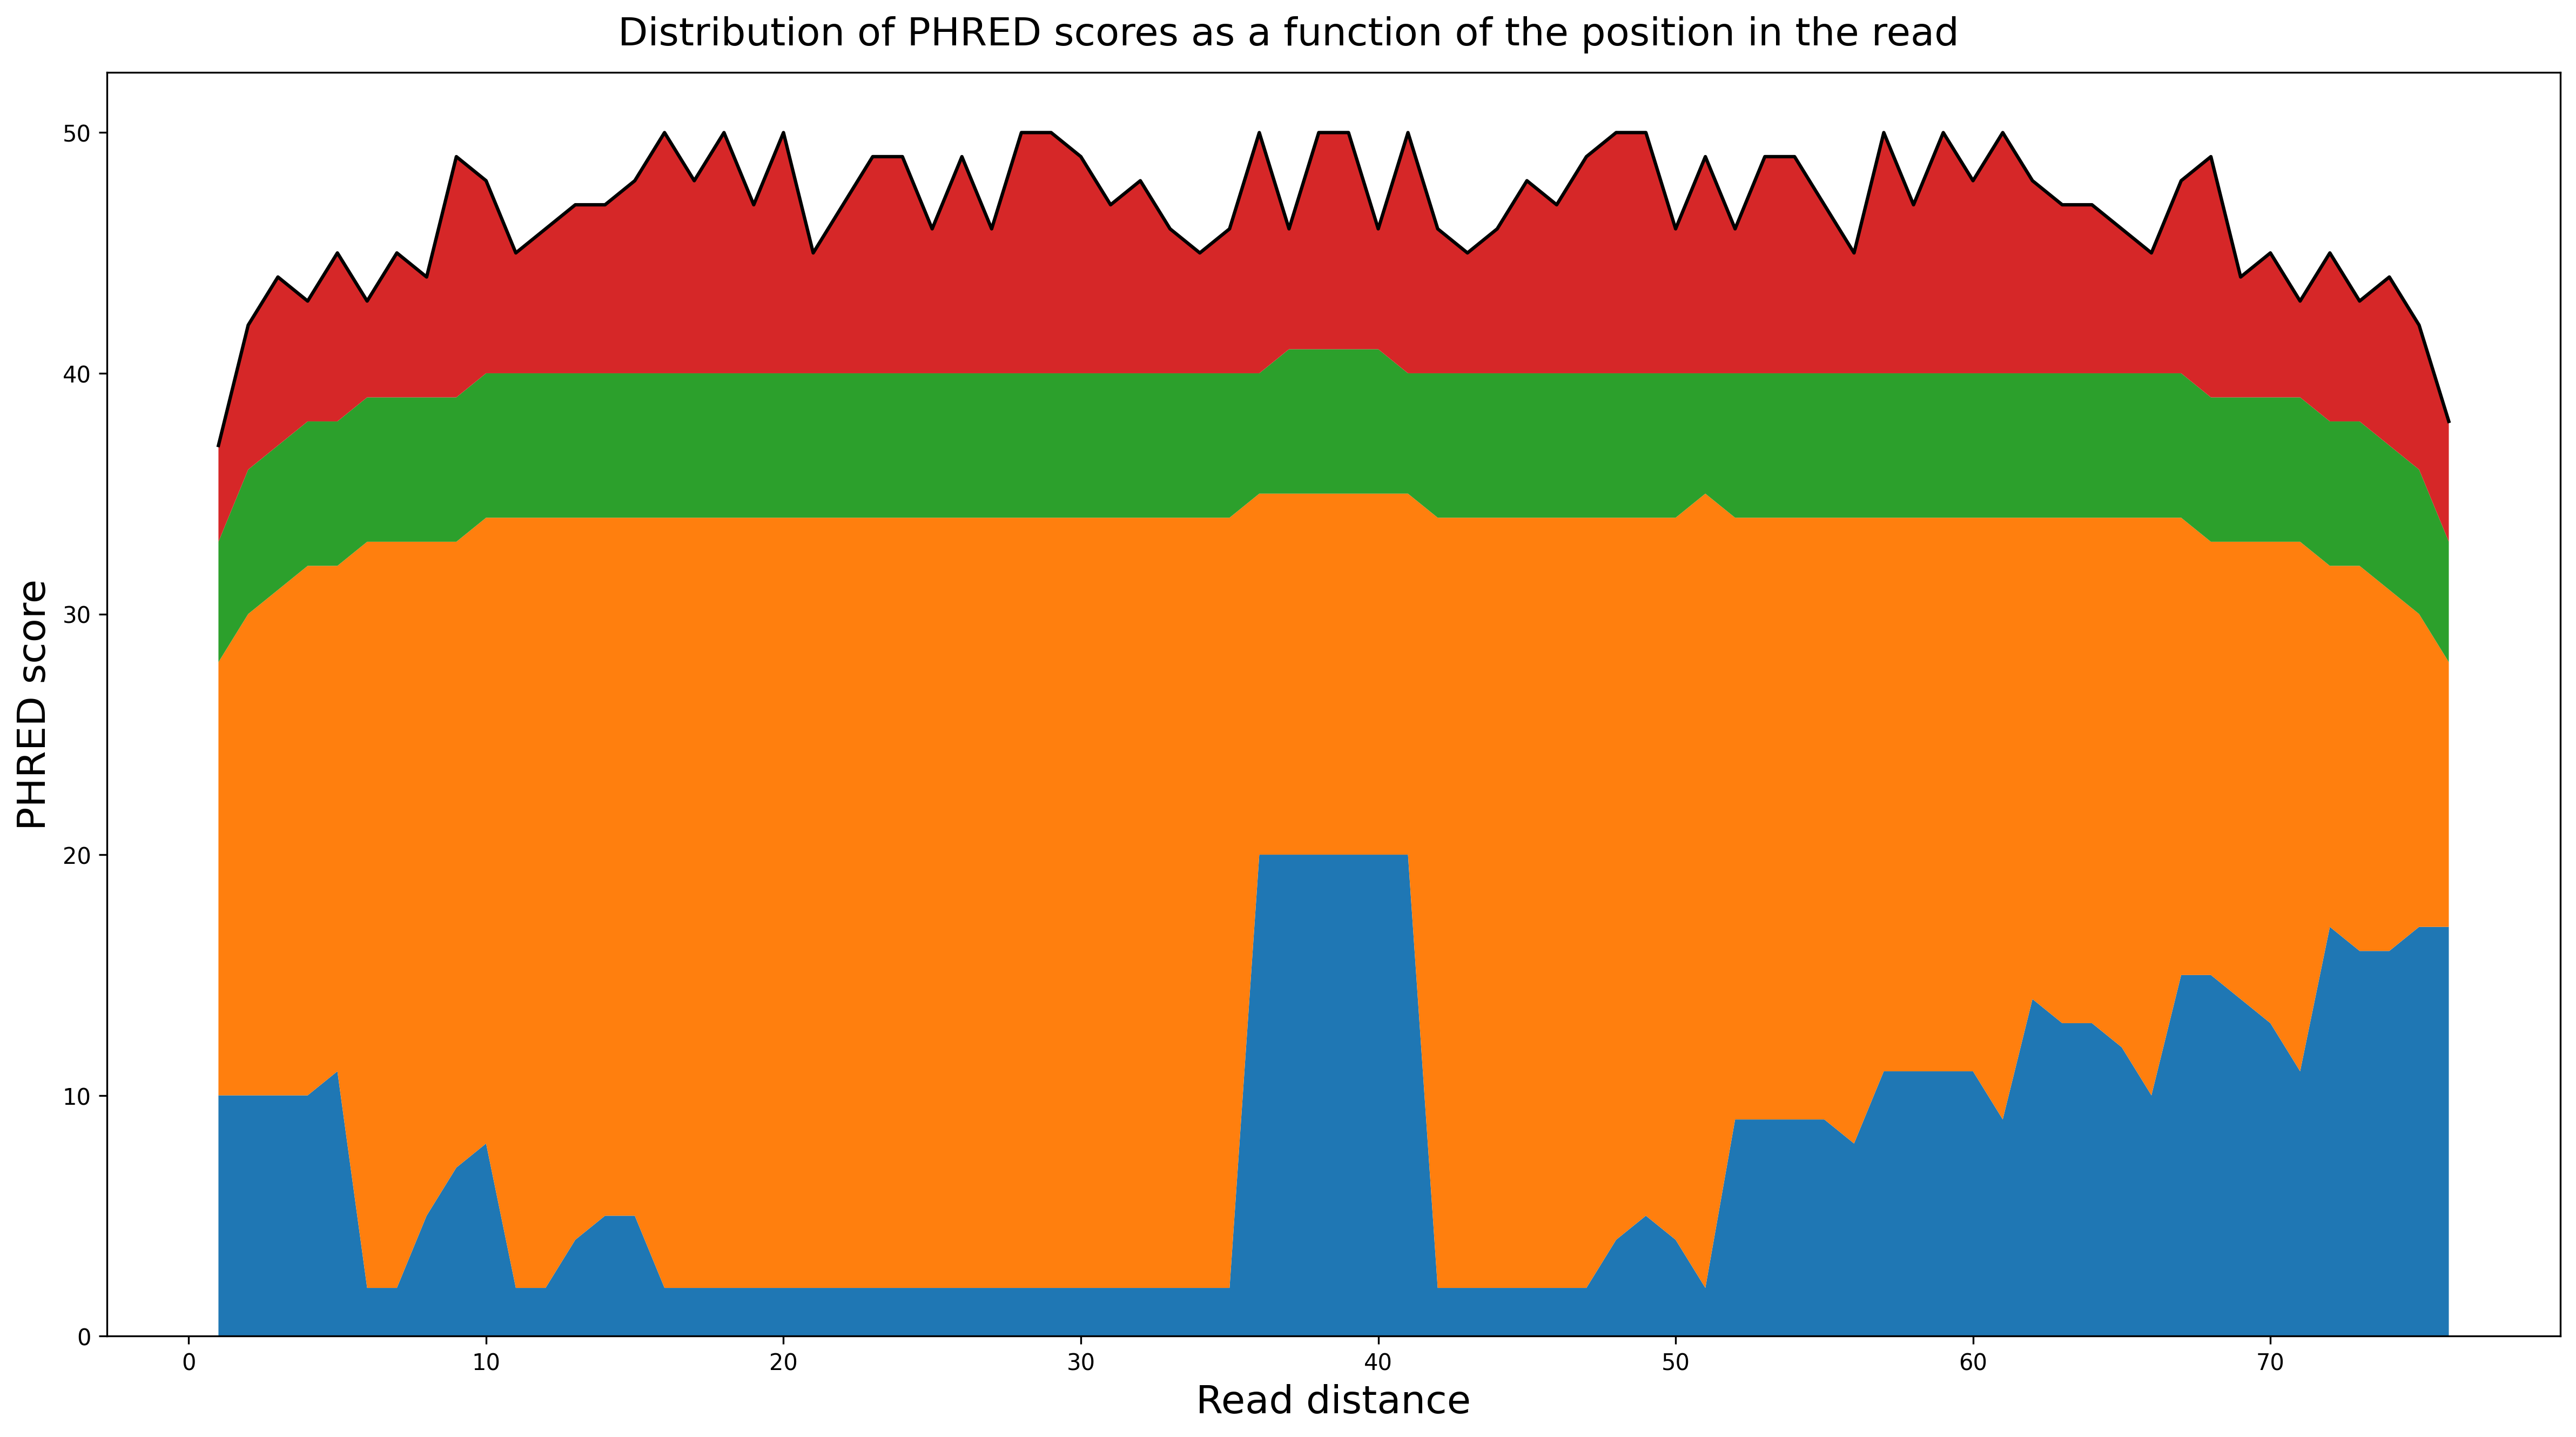

In [76]:
phreds = defaultdict(list)
for rec in bam.fetch('20', 0, None):
    for i in range(rec.query_alignment_start, rec.query_alignment_end):
        phreds[i].append(rec.query_qualities[i])
maxs = [max(phreds[i]) for i in range(76)]
tops = [np.percentile(phreds[i], 95) for i in range(76)]
medians = [np.percentile(phreds[i], 50) for i in range(76)]
bottoms = [np.percentile(phreds[i], 5) for i in range(76)]
medians_fig = [x - y for x, y in zip(medians, bottoms)]
tops_fig = [x - y for x, y in zip(tops, medians)]
maxs_fig = [x - y for x, y in zip(maxs, tops)]
fig, ax = plt.subplots(figsize=(16,9),dpi=300, tight_layout=True)
ax.stackplot(range(1, 77), (bottoms, medians_fig, tops_fig, maxs_fig))
ax.plot(range(1, 77), maxs, 'k-')
ax.set_xlabel('Read distance', fontsize='xx-large')
ax.set_ylabel('PHRED score', fontsize='xx-large')
fig.suptitle('Distribution of PHRED scores as a function of the position in the read', fontsize='xx-large')

In [80]:
#!rm -f genotypes.vcf.gz 2>/dev/null
#!tabix -fh ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/release/20130502/supporting/vcf_with_sample_level_annotation/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5_extra_anno.20130502.genotypes.vcf.gz 22:1-17000000|bgzip -c > genotypes.vcf.gz
#!tabix -p vcf genotypes.vcf.gz

In [2]:
v = VCF('genotypes.vcf.gz')
rec = next(v)
print('Variant Level information')
info = rec.INFO
for info in rec.INFO:
    print(info)
print('Sample Level Information')
for fmt in rec.FORMAT:
    print(fmt)

Variant Level information
('AC', 1)
('AF', 0.000199681002413854)
('AN', 5008)
('NS', 2504)
('DP', 8012)
('ASN_AF', 0.0)
('AMR_AF', 0.0)
('SAS_AF', '0.0010')
('EUR_AF', 0.0)
('EAS_AF', '')
('AFR_AF', 0.0)
('SAN_AF', 0.0)
Sample Level Information
GT
DP


[W::vcf_parse_info] INFO 'SAS_AF' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'EAS_AF' is not defined in the header, assuming Type=String


In [12]:
v = VCF('genotypes.vcf.gz')
"""
Retrieves a list of sample identifiers from the VCF. 
Each element in v.samples is typically a string (e.g., "Sample1", "Sample2") 
corresponding to the column headers after the FORMAT column in the VCF.
Prints how many samples are present in the VCF. 
For a dataset with, say, 100 samples, this would print 100.
"""
samples = v.samples
print(len(samples))

variant = next(v)#Obtains the first variant record (or the next one in a sequence) from the VCF object. 

print(variant.CHROM, variant.POS, variant.ID, 
      variant.REF, variant.ALT, variant.QUAL, variant.FILTER)
print(variant.INFO)
print(variant.FORMAT)
print(variant.is_snp)
print(len(variant.gt_bases))# same as len(samples)
str_alleles = variant.gt_bases[0] # Accesses the genotype bases (the actual nucleotides called) for the first sample ([0]).
"""
Accesses the raw genotype fields for the first sample—often a tuple or list. may look like:

[
  0,        # The first allele index (0 = reference, 1 = first ALT, etc.)
  1,        # The second allele index
  False,    # Whether the genotype is phased or not
  ...
]
By doing [0:3], you grab the first three elements, which typically correspond 
to allele1 index, allele2 index, and phasing boolean.
"""
alleles = variant.genotypes[0][0:3]
is_phased = variant.genotypes[0][2]
print(str_alleles, alleles, is_phased)
print(variant.format('DP')[0])

2504
22 16050075 None A ['G'] 100.0 None
['GT', 'DP']
True
2504
A|A [0, 0, True] True
1


[W::vcf_parse_info] INFO 'SAS_AF' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'EAS_AF' is not defined in the header, assuming Type=String


In [11]:
f = VCF('genotypes.vcf.gz')
my_type = defaultdict(int)
num_alts = defaultdict(int)
for variant in f:
    my_type[variant.var_type, variant.var_subtype] += 1
    if variant.var_type == 'snp':
        num_alts[len(variant.ALT)] += 1
print(my_type)

[W::vcf_parse_info] INFO 'SAS_AF' is not defined in the header, assuming Type=String
[W::vcf_parse_info] INFO 'EAS_AF' is not defined in the header, assuming Type=String


defaultdict(<class 'int'>, {('snp', 'ts'): 10054, ('snp', 'tv'): 5917, ('sv', 'CNV'): 2, ('indel', 'del'): 273, ('snp', 'unknown'): 79, ('indel', 'ins'): 127, ('indel', 'unknown'): 13, ('sv', 'DEL'): 6, ('sv', 'SVA'): 1})


In [13]:
!rm -rf centro.vcf.gz 2>/dev/null
!rm -rf standard.vcf.gz 2>/dev/null
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:1-200000 |bgzip -c > centro.vcf.gz
!tabix -fh ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/preview/ag1000g.AC.phase1.AR1.vcf.gz 3L:21000000-21200000 |bgzip -c > standard.vcf.gz       
!tabix -p vcf centro.vcf.gz
!tabix -p vcf standard.vcf.gz

[E::easy_errno] Libcurl reported error 78 (Remote file not found)
[E::easy_errno] Libcurl reported error 78 (Remote file not found)


In [30]:
def do_window(recs, size, fun):
    start = None
    win_res = []
    for rec in recs:
        if not rec.is_snp or len(rec.ALT) > 1:# Looking only for biallelic SNPs
            continue
        if start is None:
            start = rec.POS
        my_win = 1 + (rec.POS - start) // size
        """
        We will divide our file into windows of size. Every time we find a biallelic
        SNP, we will add a 1 to the list related to this window in the window function.
        """
        while len(win_res) < my_win:
            win_res.append([])
        win_res[my_win - 1].extend(fun(rec))
    # Returns a list of lists, where each sub-list corresponds to a genomic window.
    # For example, win_res[0] is window 1, win_res[1] is window 2, etc.
    return win_res 
wins = {}
size = 2000
names = ['centro.vcf.gz', 'standard.vcf.gz']
"""
We pass a lambda that returns [1] for each valid record.
This effectively means: "For each biallelic SNP, add a 1 to the window’s list."
wins[name] = ...: We store the resulting window list-of-lists in a dictionary keyed 
by the file name. As a result, wins[name] is something like [[1,1,1], [1,1], [1], ...], 
where each sub-list is one window, containing as many 1s as biallelic SNPs in that window.
"""
for name in names:
    recs = VCF(name)
    wins[name] = do_window(recs, size, lambda x: [1])

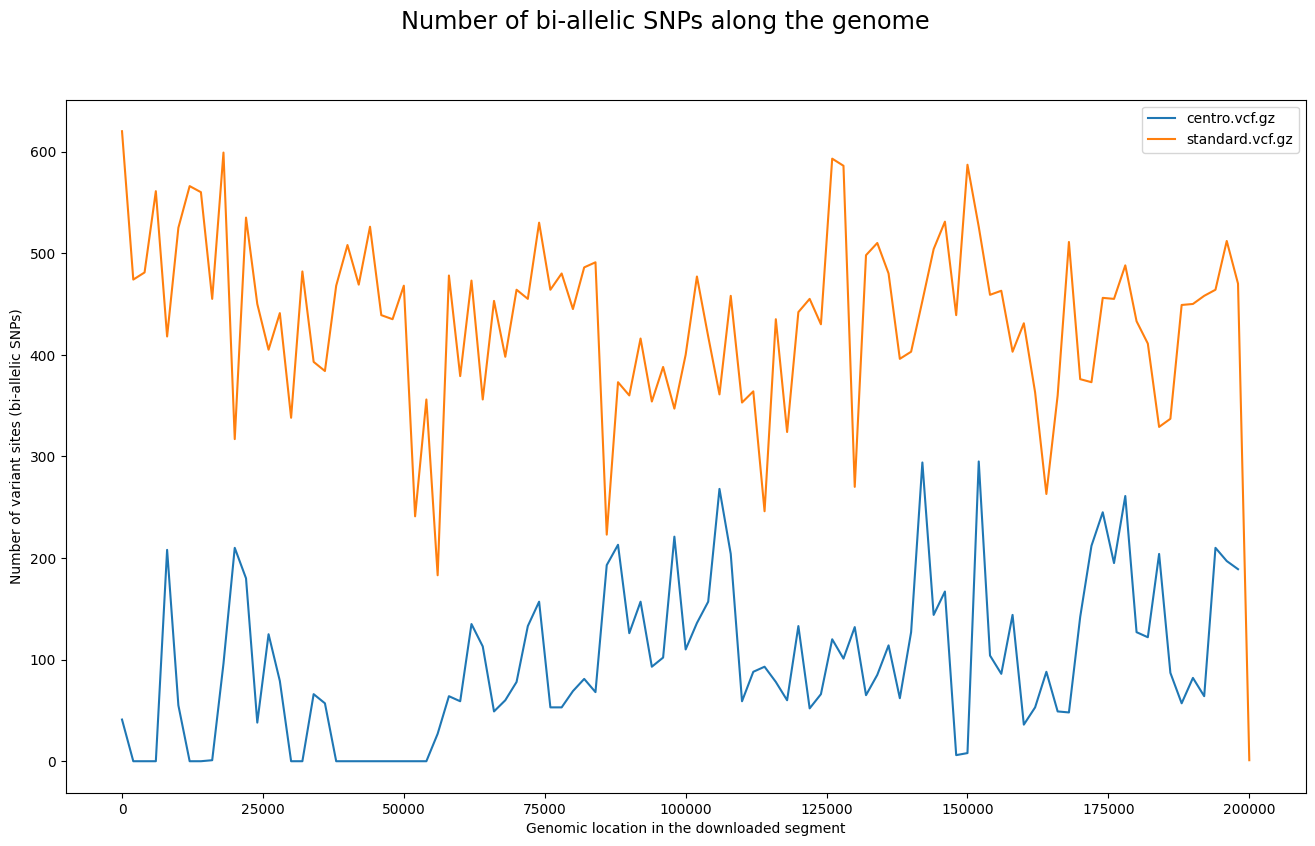

In [31]:
def apply_win_funs(wins, funs):
    """
    wins: The list of windows (each window is itself a list of items accumulated by do_window).
    funs: A dictionary of functions to apply to each window. 
    For example, {'sum': sum, 'len': len}.
    """
    fun_results = []
    for win in wins:
        my_funs = {}
        for name, fun in funs.items():
            try:
                my_funs[name] = fun(win)
            except:
                my_funs[name] = None
        fun_results.append(my_funs)
    return fun_results
stats = {}
fig, ax = plt.subplots(figsize=(16,9))
for name, nwins in wins.items():
    stats[name] = apply_win_funs(nwins, {'sum':sum})# [{'sum': 3}, {'sum': 2}, {'sum': 5}, ...]
    x_lim = [i * size for i in range(len(stats[name]))]
    ax.plot(x_lim, [x['sum'] for x in stats[name]], label=name)
    ax.legend()
    ax.set_xlabel('Genomic location in the downloaded segment')
    ax.set_ylabel('Number of variant sites (bi-allelic SNPs)')
    fig.suptitle('Number of bi-allelic SNPs along the genome', fontsize='xx-large')

In [32]:
mq0_wins = {}
size = 5000

def get_sample(rec, annot, my_type):
    """
    rec.format(annot):
    Returns a list or array of per-sample values for the field named annot 
    (in this case, 'MQ0'). 'MQ0' often denotes the number of reads with mapping 
    quality zero for each sample.
    Filtering:
    np.iinfo(my_type).min is the minimum representable integer for the given 
    type (-2,147,483,648 for int32). By doing if v > np.iinfo(my_type).min, this 
    line filters out sentinel (belirli bir blogun basini veya sonunu gostermek icin 
    kullanilan karakter) values or missing data that might be stored as the 
    minimum integer. The returned list will contain only valid 'MQ0' values that 
    exceed that sentinel.
    Return:
    A list of valid MQ0 values for all samples in the variant record.
    For example, if there are 10 samples in the VCF, and each has an MQ0 value, 
    you might get a list of 10 integers (with invalid or missing ones removed).
    """
    return [v for v in rec.format(annot) if v > np.iinfo(my_type).min]
"""
Python allows to specify some parameters of a function and wait for other parameters 
to be specified later. functools.partial(get_sample, annot='MQ0', my_type=np.int32) rec will be
specified later.
"""
for name in names:
    recs = VCF(name)
    mq0_wins[name] = do_window(recs, size, functools.partial(get_sample, annot='MQ0', my_type=np.int32))
"""
recs = VCF(name):
Opens the VCF file named name and creates an iterator of variant records.
do_window(recs, size, functools.partial(...)):
Uses previously defined do_window function to iterate over 
these VCF records in windows of length size (5,000 bp).
The third argument to do_window is a function that is 
applied to each variant record in each window.
functools.partial(get_sample, annot='MQ0', my_type=np.int32):
Creates a partial function from get_sample, essentially pre-filling the annot='MQ0' 
and my_type=np.int32 arguments. This partial is called as fun(rec), 
which translates to get_sample(rec, 'MQ0', np.int32) inside do_window.
Storing results: mq0_wins[name] = ... stores the windowed results in the dictionary mq0_wins.
The output structure from do_window is a list of windows, and each window 
is a list of lists of MQ0 values (since get_sample itself returns a list).
mq0_wins[name] = [
    [ <MQ0 values for window 1> ],
    [ <MQ0 values for window 2> ],
    ...
]
"""
    

"\nrecs = VCF(name):\nOpens the VCF file named name and creates an iterator of variant records.\ndo_window(recs, size, functools.partial(...)):\nUses previously defined do_window function to iterate over \nthese VCF records in windows of length size (5,000 bp).\nThe third argument to do_window is a function that is \napplied to each variant record in each window.\nfunctools.partial(get_sample, annot='MQ0', my_type=np.int32):\nCreates a partial function from get_sample, essentially pre-filling the annot='MQ0' \nand my_type=np.int32 arguments. This partial is called as fun(rec), \nwhich translates to get_sample(rec, 'MQ0', np.int32) inside do_window.\nStoring results: mq0_wins[name] = ... stores the windowed results in the dictionary mq0_wins.\nThe output structure from do_window is a list of windows, and each window \nis a list of lists of MQ0 values (since get_sample itself returns a list).\nmq0_wins[name] = [\n    [ <MQ0 values for window 1> ],\n    [ <MQ0 values for window 2> ],\n   

Text(0.5, 0.98, 'Distribution of MQ0 along the genome')

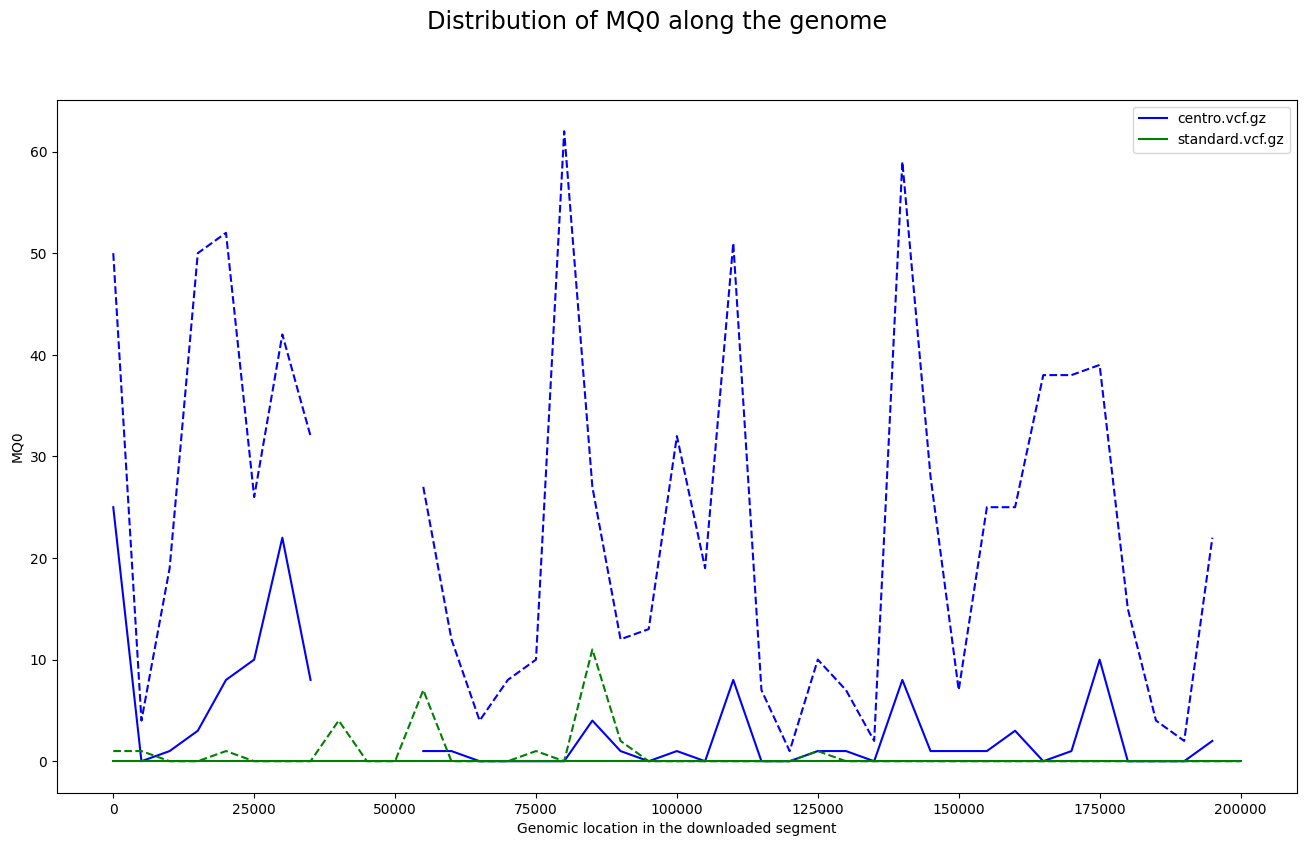

In [34]:
stats = {}
colors = ['b', 'g']
i = 0
fig, ax = plt.subplots(figsize=(16,9))
"""
This loop iterates through the dictionary mq0_wins, where:
name is the filename or key (e.g., "centro.vcf.gz" or "standard.vcf.gz").
nwins is the list of windows produced by do_window 
(each window is a list of valid MQ0 values across variants in that window).
"""
for name, nwins in mq0_wins.items():
    """
    [
      {'median': 25.0, '95': 40.0},  # for window 1
      {'median': 30.0, '95': 50.0},  # for window 2
      ...
    ]
    """
    stats[name] = apply_win_funs(nwins, {'median':np.median, '95':functools.partial(np.percentile, q=95)})
    x_lim = [j * size for j in range(len(stats[name]))]
    ax.plot(x_lim, [x['median'] for x in stats[name]], label=name, color=colors[i])
    ax.plot(x_lim, [x['95'] for x in stats[name]], '--', color=colors[i])
    i += 1
ax.legend()
ax.set_xlabel('Genomic location in the downloaded segment')
ax.set_ylabel('MQ0')
fig.suptitle('Distribution of MQ0 along the genome', fontsize='xx-large')

Text(0.5, 0.98, 'Number of calls per depth and fraction of calls which are Hz')

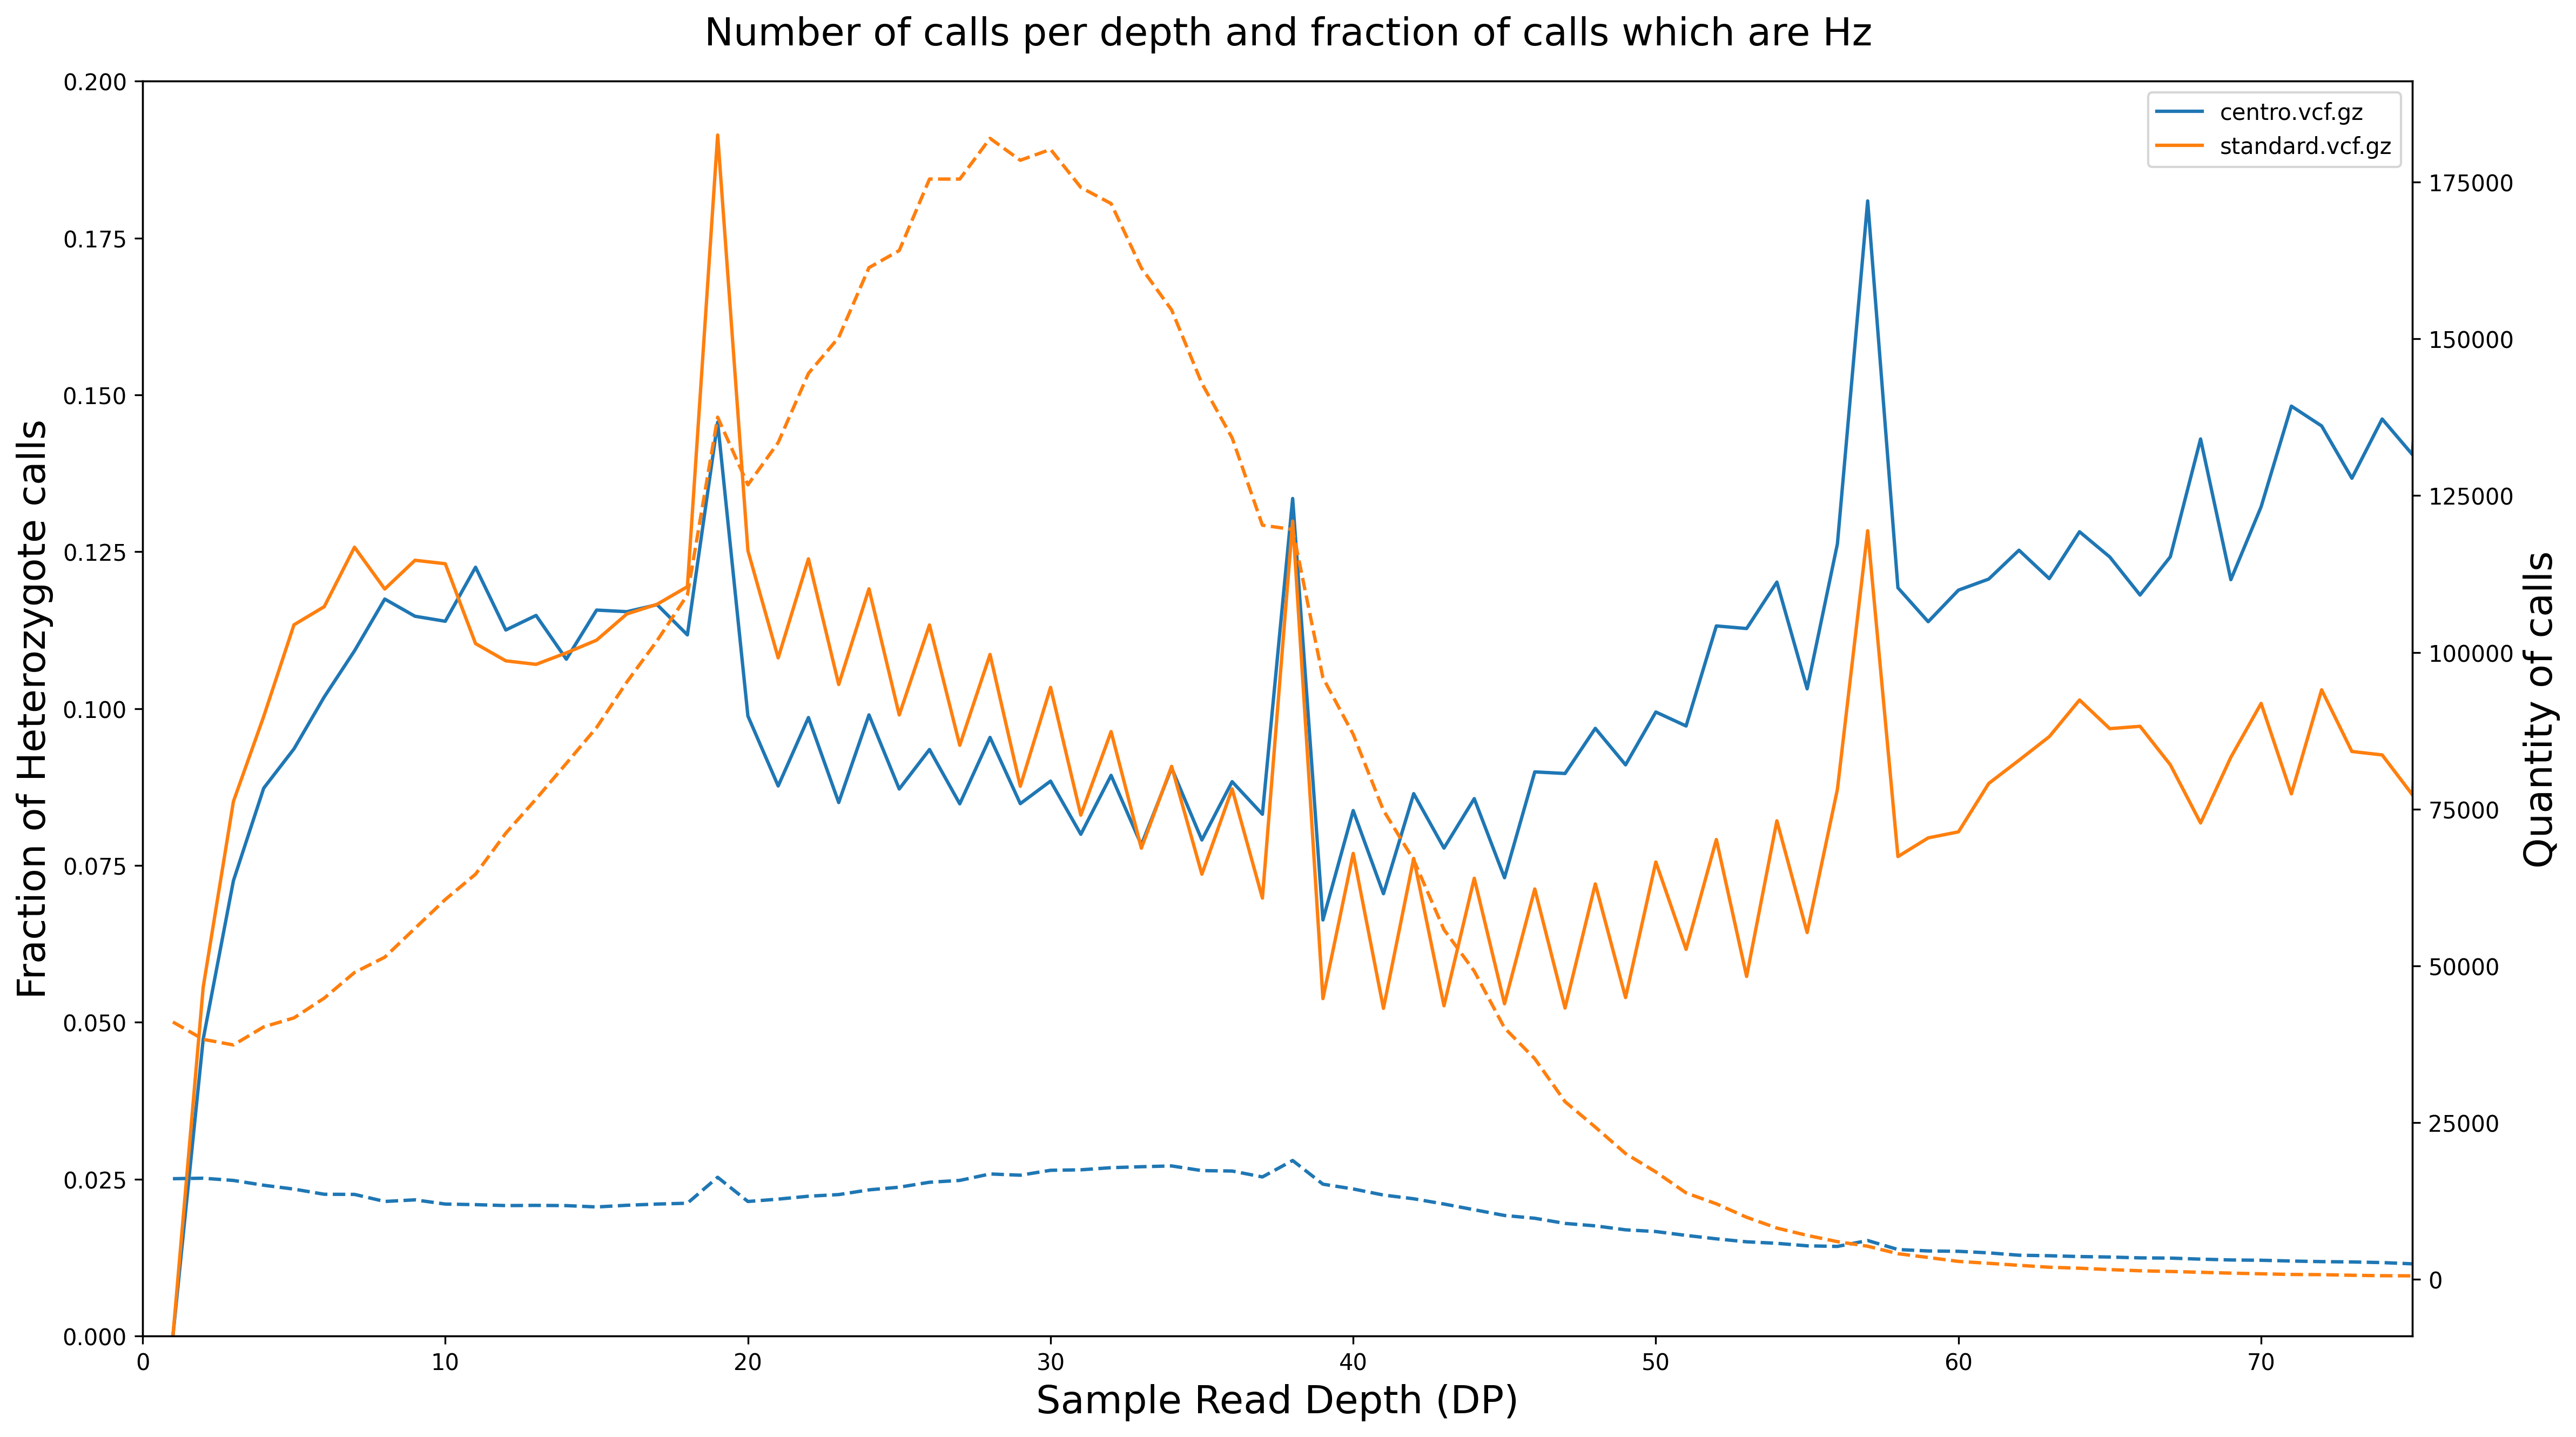

In [40]:
def get_sample_relation(recs, f1, f2):
    """
    recs: An iterable of VCF variant records.
    f1 and f2: Functions that take a variant record (rec) and a sample index (pos) and 
    return some numeric or categorical value.
    f1 determines if the sample is heterozygous (returns 1) or homozygous (0), and 
    f2 retrieves the read depth (DP) for that same sample.
    """
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
            continue
        for pos in range(len(rec.genotypes)):
            v1 = f1(rec, pos)# v1 indicates heterozygous (1) vs. homozygous (0).
            v2 = f2(rec, pos)# v2 indicates the sample’s read depth (DP).
            if v1 is None or v2 == np.iinfo(type(v2)).min:
                continue# Sometimes missing or sentinel values (like -2,147,483,648 for int32) indicate “no valid data.”
            rel[(v1, v2)] += 1# (v1, v2) is a tuple like (0, 12) or (1, 30), meaning “(homozygous=0, DP=12)” or “(heterozygous=1, DP=30).”
    return rel
    
rels = {}
for name in names:
    recs = VCF(name)
    rels[name] = get_sample_relation(recs, 
                                     lambda rec, pos: 1 if rec.genotypes[pos][0] != rec.genotypes[pos][1] else 0, 
                                     lambda rec, pos: rec.format('DP')[pos][0])

"""
rec.format('DP'): In many Python VCF libraries, rec.format('FIELD') returns a 2D array or 
list of lists containing the values of that FORMAT field across all samples.
The first dimension is the sample index (pos), so rec.format('DP')[pos] is the DP-related 
data for sample pos. The second dimension often corresponds to multiple sub-values of the 
same field or an array representation. Some genotype fields are single integers 
(like DP typically is), yet the library may still store them as arrays, e.g., [42].
In practice, if DP is truly a single integer per sample, it’s often stored in a 
length-1 array or tuple, so [pos][0] extracts that one integer. 
If DP had multiple components (less common), the [0] might pick the first of several.
DP often should be a single integer per sample, but depending on the library’s data model, 
it might still be returned as something like [42]. We take [0] because that’s the 
actual integer value.
Example:
If rec.format('DP') for 3 samples is [ [42], [36], [50] ], then:
For sample pos=0, rec.format('DP')[0] is [42], and rec.format('DP')[0][0] is 42.
"""

fig, ax = plt.subplots(figsize=(16, 9), dpi=300, tight_layout=True)

def plot_hz_rel(dps, ax, ax2, name, rel):
    """
    dps: A sorted list of distinct DP values encountered in the data (e.g., [0, 1, 2, 3, 4, ... 100]).
    ax: The left y-axis for plotting fraction heterozygotes.
    ax2: A second y-axis (right side) for plotting the total number of calls.
    name: A label for the dataset (e.g., the VCF file name).
    rel: The dictionary of (heterozygous_flag, DP) -> count.
    """
    frac_hz = []
    cnt_dp = []
    for dp in dps:
        hz = 0.0 # A running total of heterozygous calls at this DP.
        cnt = 0 # Total calls at this DP.
        for khz, kdp in rel.keys():
            if kdp != dp:
                continue
            cnt += rel[(khz, dp)]
            if khz == 1: # if heterozygous 
                hz += rel[(khz, dp)]
        frac_hz.append(hz/cnt) # fraction of heterozygous
        cnt_dp.append(cnt)
    ax.plot(dps, frac_hz, label=name)
    ax2.plot(dps, cnt_dp, '--', label=name)

ax2 = ax.twinx()
for name, rel in rels.items():
    dps = list(set([x[1] for x in rel.keys()])) 
    dps.sort() # sorting DP values in a list
    plot_hz_rel(dps, ax, ax2, name, rel)
ax.set_xlim(0, 75)
ax.set_ylim(0, 0.2)
ax2.set_ylabel('Quantity of calls', fontsize='xx-large')
ax.set_ylabel('Fraction of Heterozygote calls', fontsize='xx-large')
ax.set_xlabel('Sample Read Depth (DP)', fontsize='xx-large')
ax.legend()
fig.suptitle('Number of calls per depth and fraction of calls which are Hz', fontsize='xx-large')

/tmp/ipykernel_31636/2966790290.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(accepted_eff + ['OTHER'])


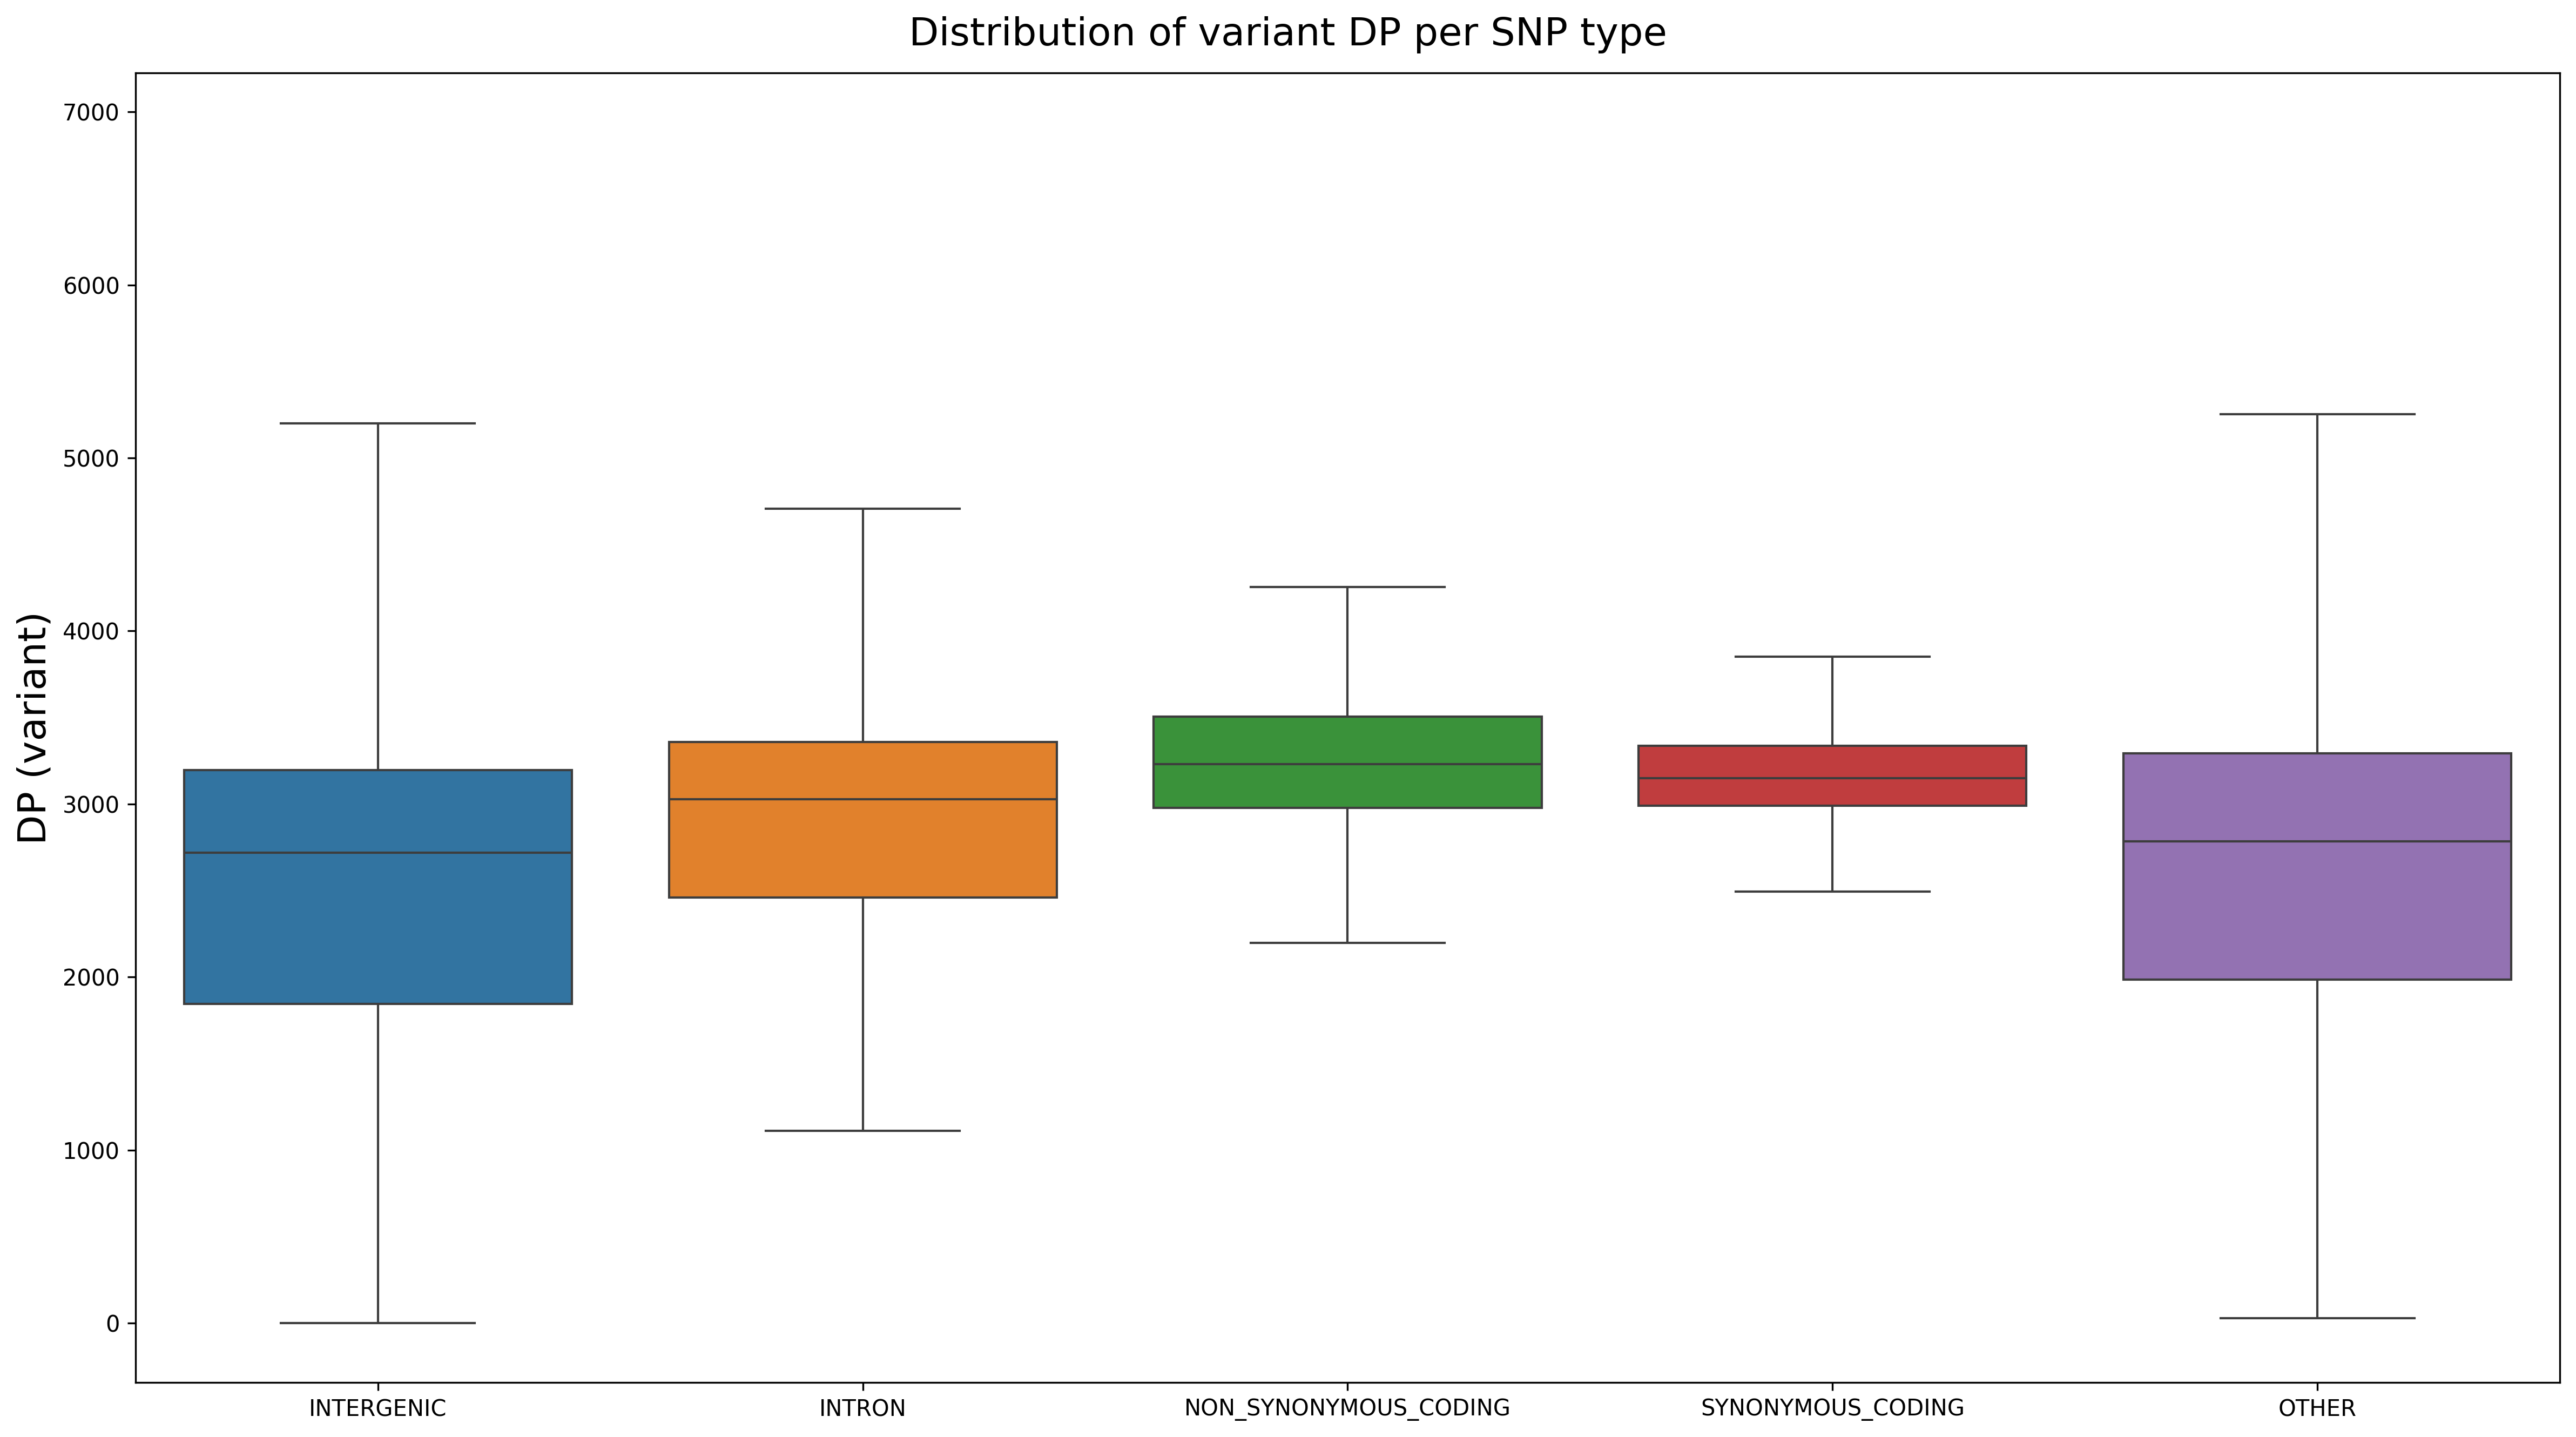

In [43]:
def get_variant_relation(recs, f1, f2):
    rel = defaultdict(int)
    for rec in recs:
        if not rec.is_snp:
            continue
        try:
            v1 = f1(rec)
            v2 = f2(rec)
            if v1 is None or v2 is None:
                continue
            rel[(v1, v2)] += 1
        except:
            pass
    return rel


accepted_eff = ['INTERGENIC', 'INTRON', 'NON_SYNONYMOUS_CODING', 'SYNONYMOUS_CODING']

def eff_to_int(rec):
    """
    Collect relationships between two variant-level metrics, v1 and v2, across all SNP records in a VCF file.
    Store these relationships in a dictionary where keys are (v1, v2) pairs and values are counts of how often that pair appears.
    {
      (some_v1, some_v2): count,
      (other_v1, other_v2): count,
      ...
    }    
    In a typical SnpEff-annotated VCF, EFF might look like:

    "NON_SYNONYMOUS_CODING(MODERATE|MISSENSE|blah|...)"

    rec.INFO is a Python dictionary. By using rec.INFO['EFF'], 
    we get the string associated with the EFF key. master_type = annot.split("(")[0]

    Takes the substring before the first parentheses "(".
    For example, if annot = "NON_SYNONYMOUS_CODING(MODERATE|...)"
        annot.split("(") becomes ["NON_SYNONYMOUS_CODING", "MODERATE|..."].
    """
    try:
        annot = rec.INFO['EFF']
        master_type = annot.split("(")[0]
        return accepted_eff.index(master_type)
    except ValueError:
        return len(accepted_eff)

eff_mq0s = {}
for name in names:
    recs = VCF(name)
    eff_mq0s[name] = get_variant_relation(
        recs,
        lambda r: eff_to_int(r), lambda r: int(r.INFO['DP']))
"""
lambda r: int(r.INFO['DP'])

This retrieves the DP field from rec.INFO and converts it to an integer.
Notice that r.INFO['DP'] is the variant-level read depth 
(often aggregated over all samples at this locus or computed differently 
by your variant caller).
"""

fig, ax = plt.subplots(figsize=(16,9), dpi=300, tight_layout=True)
name = 'standard.vcf.gz'
bp_vals = [[] for x in range(len(accepted_eff) + 1)]
for k, cnt in eff_mq0s[name].items():
    my_eff, mq0 = k
    bp_vals[my_eff].extend([mq0] * cnt)
    #memory usage
#print(bp_vals[-2])
sns.boxplot(data=bp_vals, fliersize=0, ax=ax)
ax.set_xticklabels(accepted_eff + ['OTHER'])
ax.set_ylabel('DP (variant)', fontsize='xx-large')
fig.suptitle('Distribution of variant DP per SNP type',
             fontsize='xx-large')
fig.savefig('eff.png')